In [7]:
import pandas as pd
from django.contrib.admin import display
import numpy as np
from functools import reduce
import matplotlib.pylab as plt
from darts import TimeSeries
from darts.models import AutoARIMA

In [193]:
pd.set_option('display.max.columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
         2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Creating a list with dataframes years 2009 - 2024

In [215]:
file_list = []
for i in range(len(years)):
    if i < 7:
        df = pd.read_excel(f'Systembolaget/Försäljning per artikel/Artikellistan_{years[i]}.xlsx')
        file_list.append(df)
    else:
        df = pd.read_excel(f'Systembolaget/Försäljning per artikel/Artikellistan_{years[i]}.xlsx')[3:]
        df.rename(columns=df.iloc[0], inplace=True)
        df.drop(df.index[0], inplace=True)
        df.reset_index(drop=True, inplace=True)
        file_list.append(df)

Calculating revenue for each year

In [11]:
revenue_list = []
for i in range(len(years)):
    file_list[i]['Försäljning i SEK'] = (
            1000 * (file_list[i]['Försäljning i liter'] / file_list[i]['Volym i ml'].mask(file_list[i]['Volym i ml'].eq(0))) * file_list[i]['Aktuellt pris'])
    df1 = file_list[i]['Försäljning i SEK'].sum()
    revenue_list.append(df1)

Adding a percent change column

In [194]:
revenue_df = pd.DataFrame({'Revenue': revenue_list, 'Year': years})
revenue_df.set_index('Year', inplace=True)
revenue_df['Percent change'] = revenue_df.pct_change()
display(revenue_df)

,Revenue,Percent change
Year,,
2009,29322172702.743,NaN
2010,29912175700.136,0.020
2011,30378621477.100,0.016
2012,31283991955.373,0.030
2013,31990569358.780,0.023
2014,32920725779.292,0.029
2015,34451326644.808,0.046
2016,35417702690.167,0.028
2017,36569076775.720,0.033


Plotting revenue

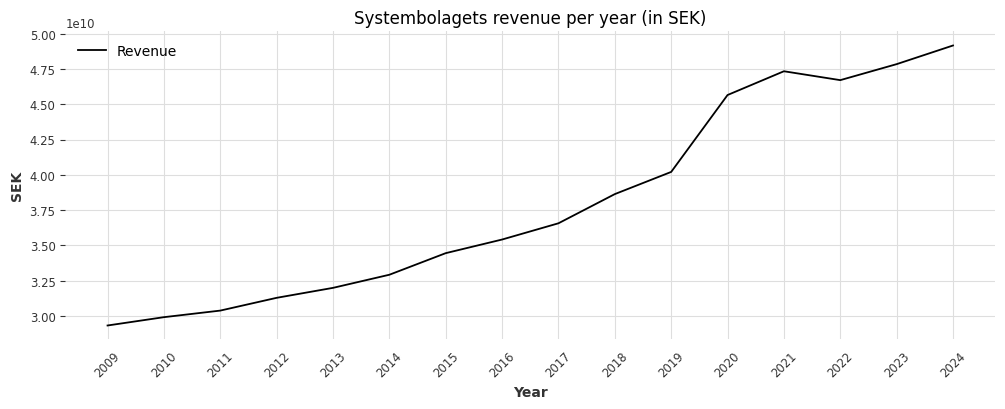

In [242]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(revenue_list, label = 'Revenue')
plt.grid(True)
plt.title('Systembolagets revenue per year (in SEK)')
plt.xlabel('Year')
ax.set_xticks(range(0, len(years)))
ax.set_xticklabels(labels=years, rotation=45)
plt.ylabel('SEK')
plt.legend(loc='upper left')
plt.show()

Revenue forecast for 5 years (2025-2030)

In [14]:
rvn_series = TimeSeries.from_dataframe(revenue_df, value_cols='Revenue')
rvn_train, rvn_val = rvn_series, rvn_series
rvn_model = AutoARIMA()
rvn_model.fit(rvn_train)
rvn_prediction = rvn_model.predict(5, num_samples=100)

Plotting prediction for revenue

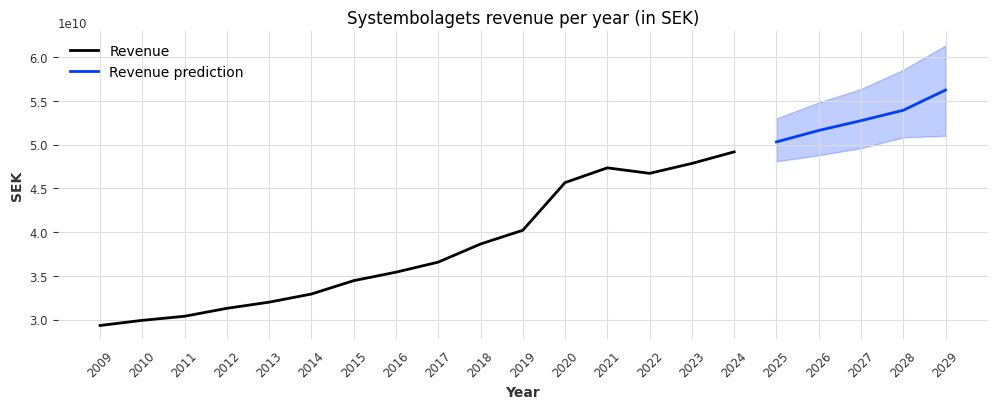

In [221]:
fig, ax = plt.subplots(figsize=(12, 4))
rvn_series.plot()
rvn_prediction.plot(label='Revenue prediction')
plt.legend()
plt.title('Systembolagets revenue per year (in SEK)')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(2009, 2030))
ax.set_xticklabels(np.arange(2009, 2030),rotation=45)
ax.set_ylabel('SEK')
plt.show()

In [223]:
rvn_prediction.mean()

<TimeSeries (DataArray) (Year: 5, component: 1, sample: 1)> Size: 40B
array([[[5.03428525e+10]],

       [[5.16904790e+10]],

       [[5.29764551e+10]],

       [[5.43336071e+10]],

       [[5.60246996e+10]]])
Coordinates:
  * Year       (Year) int64 40B 2025 2026 2027 2028 2029
  * component  (component) object 8B 'Revenue'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

Grouping by the group of alcohol (Whisky, Wine, Beer+Cider+Other, Alcoholfree) and calculation of volume sold per group

In [16]:
group_list = []
for i in range(len(years)):
    group_df = file_list[i].groupby('Varugrupp')['Försäljning i liter'].sum().to_frame()
    group_df.rename(columns={'Försäljning i liter' : f'Försäljning i liter år {years[i]}'}, inplace=True)
    group_list.append(group_df)

In [196]:
merged_group_files = reduce(lambda left, right: pd.merge(left, right, on = 'Varugrupp', how='inner'), group_list)
display(merged_group_files)

,Försäljning i liter år 2009,Försäljning i liter år 2010,Försäljning i liter år 2011,Försäljning i liter år 2012,Försäljning i liter år 2013,Försäljning i liter år 2014,Försäljning i liter år 2015,Försäljning i liter år 2016,Försäljning i liter år 2017,Försäljning i liter år 2018,Försäljning i liter år 2019,Försäljning i liter år 2020,Försäljning i liter år 2021,Försäljning i liter år 2022,Försäljning i liter år 2023,Försäljning i liter år 2024
Varugrupp,,,,,,,,,,,,,,,,
Alkoholfritt,1022515.490,1337043.610,1677769.945,2211547.715,2424619.310,2760486.040,3088787.190,3421166.055,3361629.090,3568122.455,3719489.700,3146602.635,3258662.205,3320443.915,3553756.565,3922958.270
Sprit,20032549.760,19926453.415,19371367.010,19290289.870,18824356.130,18257018.200,18661083.255,18813947.435,18949016.565,19465606.485,20280012.225,24094204.710,25575929.342,24372188.855,23728883.408,23458570.488
Vin,181443863.210,187900528.528,191057233.151,194549997.259,197912082.282,197816127.293,197578547.785,199258793.710,199562462.076,203691620.186,205048582.156,223878945.614,222600462.207,214932027.002,211990589.813,209692240.310
"Öl, cider & blanddryck",246346790.091,244993791.271,246055309.686,245623336.277,248978564.853,251456211.808,251223097.404,253848728.080,257027718.265,278029809.516,282676741.131,317805059.514,325390238.975,315610503.170,316044099.563,324368579.511


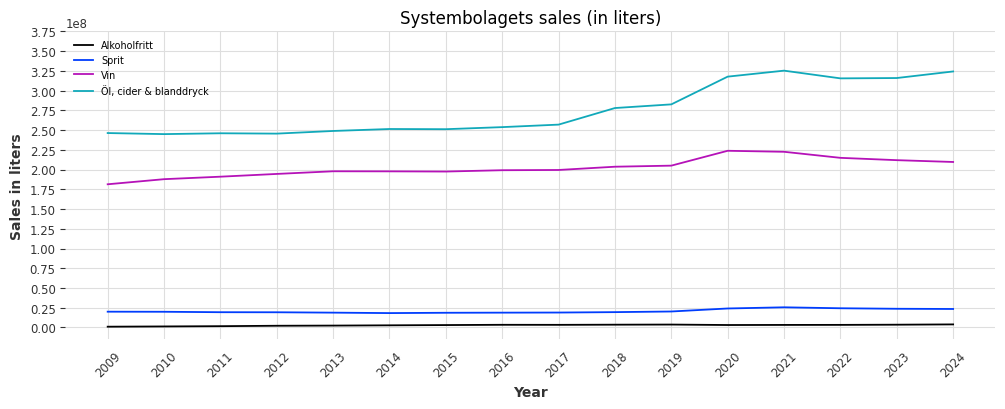

In [293]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(merged_group_files.transpose(), label=merged_group_files.index.transpose().to_list())
plt.grid(True)
plt.title('Systembolagets sales (in liters)')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='best',fontsize="x-small")
plt.ylabel('Sales in liters')
ax.set_yticks(np.arange(0, 4e+8, 0.25e+8))
plt.show()

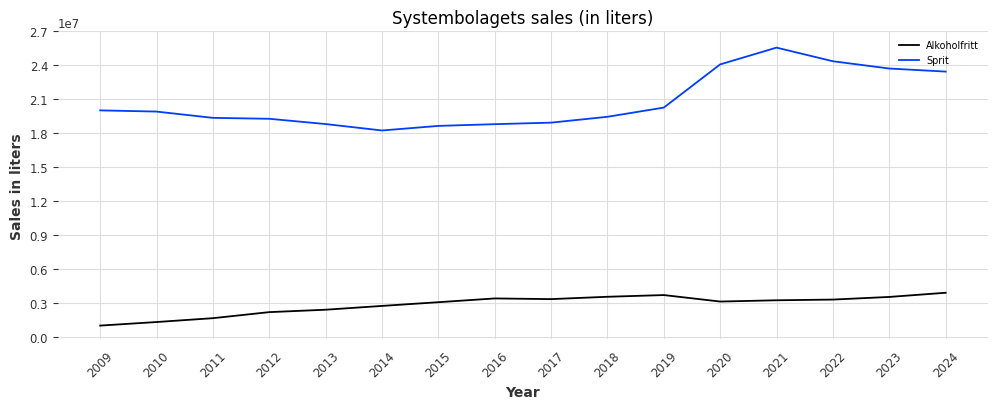

In [294]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(merged_group_files.transpose().iloc[:, :2], label=merged_group_files.index.transpose().to_list()[:2])
plt.grid(True)
plt.title('Systembolagets sales (in liters)')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='best',fontsize="x-small")
plt.ylabel('Sales in liters')
ax.set_yticks(np.arange(0, 3e+7, 0.3e+7))
plt.show()

Calculation of average price of a bottle for each group

In [192]:
avg_list = []
for i in range(len(years)):
    avg_df = file_list[i][file_list[i]['Volym i ml'] <= 1000][['Artnr', 'Artikel ID', 'Varugrupp', 'Aktuellt pris']].copy()
    avg_df.rename(columns={'Aktuellt pris' : f'Aktuellt pris år {years[i]}'}, inplace=True)
    avg_list.append(avg_df)

In [22]:
merged_avg = reduce(lambda left, right: pd.merge(left, right, on = ['Artnr', 'Artikel ID', 'Varugrupp'], how='inner'), avg_list)
avg_sum = merged_avg.groupby('Varugrupp').sum().drop(['Artnr', 'Artikel ID'], axis=1)
avg_sum = avg_sum.merge(merged_avg['Varugrupp'].value_counts(), on = 'Varugrupp')
avg_sum = avg_sum.iloc[:, :-1].div(avg_sum.iloc[:,-1], axis=0)
display(avg_sum)

,Aktuellt pris år 2009,Aktuellt pris år 2010,Aktuellt pris år 2011,Aktuellt pris år 2012,Aktuellt pris år 2013,Aktuellt pris år 2014,Aktuellt pris år 2015,Aktuellt pris år 2016,Aktuellt pris år 2017,Aktuellt pris år 2018,Aktuellt pris år 2019,Aktuellt pris år 2020,Aktuellt pris år 2021,Aktuellt pris år 2022,Aktuellt pris år 2023,Aktuellt pris år 2024
Varugrupp,,,,,,,,,,,,,,,,
Alkoholfritt,19.950000,19.950000,19.950000,22.450000,22.450000,22.450000,22.450000,25.25,26.75,26.75,26.8,27.95,27.95,27.95,30.95,30.95
Sprit,313.613466,315.471322,317.326683,322.142145,328.568579,336.488778,341.551122,343.638404,354.261845,363.820449,370.967581,380.688279,387.805486,409.563591,436.977556,455.274314
Vin,147.368557,147.805412,147.095361,147.485825,148.975515,152.840206,158.029639,160.170103,166.740979,173.135309,179.832474,184.323454,186.715206,198.007732,218.262887,229.217784
"Öl, cider & blanddryck",21.359124,21.618978,21.742336,21.906569,21.957664,22.491971,23.295620,23.511679,23.788321,23.971533,24.343066,24.781022,25.045985,26.360584,27.862774,28.605839


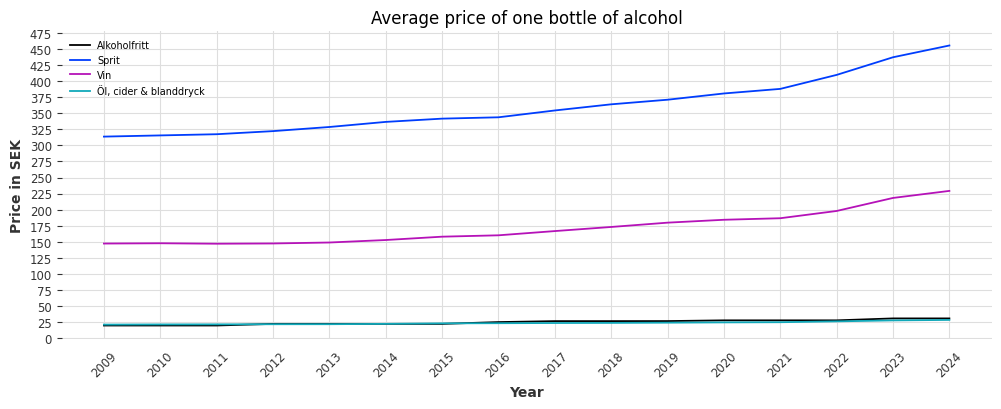

In [225]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(avg_sum.transpose(), label = avg_sum.index.transpose().to_list())
plt.grid(True)
plt.title('Average price of one bottle of alcohol')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='upper left',fontsize="x-small")
plt.ylabel('Price in SEK')
ax.set_yticks(np.arange(0, 500, 25))
plt.show()

Calculation of the average price of a bottle of lager beer throughout the years

In [279]:
lager_list = []
for i in range(len(years)):
    lager_df = file_list[i][(file_list[i]['Varugrupp detalj'].isin(['Lageröl', 'Ljus lager'])) & (file_list[i]['Aktuellt pris'] < 100)][['Artnr', 'Artikel ID', 'Aktuellt pris']].copy()
    lager_df.rename(columns={'Aktuellt pris' : f'{years[i]}'}, inplace=True)
    lager_list.append(lager_df)

merged_lager = reduce(lambda left, right: pd.merge(left, right, on = ['Artnr', 'Artikel ID'], how='inner'), lager_list)
lager_price = merged_lager.sum().drop(['Artnr', 'Artikel ID'])
lager_price = lager_price.div(len(merged_lager))
lager_price = lager_price.to_frame()
lager_price.columns = ['Average price']
lager_price.index.name = 'Year'
lager_price.index = lager_price.index.astype(int)
pd.set_option('future.no_silent_downcasting', True)
lager_price['Percent change'] = lager_price.pct_change()
display(lager_price)

,Average price,Percent change
Year,,
2009,15.953,NaN
2010,16.250,0.019
2011,16.466,0.013
2012,16.750,0.017
2013,16.750,0.000
2014,17.197,0.027
2015,17.856,0.038
2016,18.008,0.008
2017,18.116,0.006


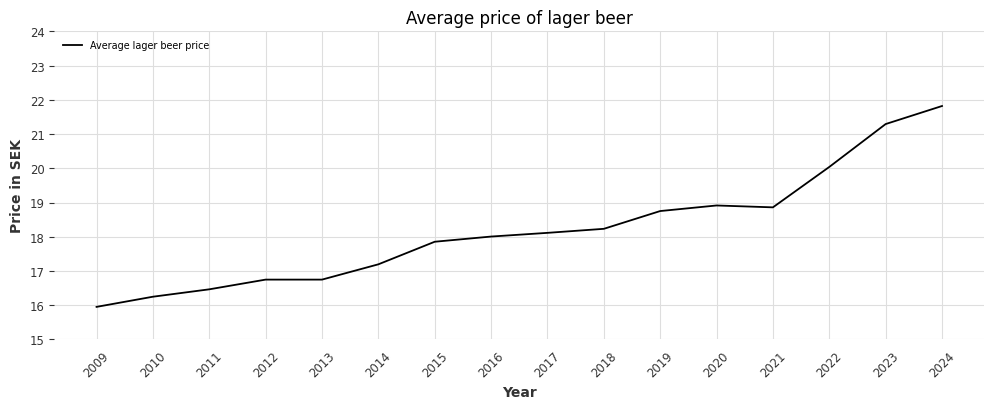

In [253]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(lager_price.iloc[:, :1], label = 'Average lager beer price')
plt.grid(True)
plt.title('Average price of lager beer')
plt.xlabel('Year')
ax.set_xticks(np.arange(2009, 2025, 1))
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='upper left', fontsize="x-small")
plt.ylabel('Price in SEK')
ax.set_yticks(np.arange(15, 25, 1))
plt.show()

In [285]:
lgr_prediction.mean()

<TimeSeries (DataArray) (Year: 5, component: 1, sample: 1)> Size: 40B
array([[[22.17635316]],

       [[22.48263361]],

       [[23.10772914]],

       [[23.38748116]],

       [[23.75762743]]])
Coordinates:
  * Year       (Year) int64 40B 2025 2026 2027 2028 2029
  * component  (component) object 8B 'Average price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

Prediction for the average price for years 2025-2030

In [34]:
lgr_series = TimeSeries.from_dataframe(lager_price, value_cols='Average price')
lgr_train, lgr_val = lgr_series, lgr_series
lgr_model = AutoARIMA()
lgr_model.fit(lgr_train)
lgr_prediction = lgr_model.predict(5, num_samples=100)

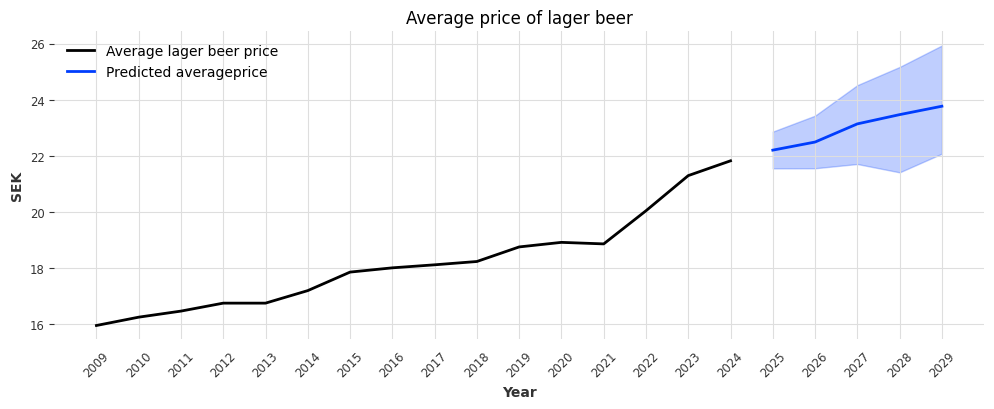

In [254]:
fig, ax = plt.subplots(figsize=(12, 4))
lgr_series.plot(label='Average lager beer price')
lgr_prediction.plot(label='Predicted averageprice')
plt.legend()
plt.title('Average price of lager beer')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(2009, 2030))
ax.set_xticklabels(np.arange(2009, 2030),rotation=45)
ax.set_ylabel('SEK')
plt.show()

In [255]:
lgr_prediction.mean()

<TimeSeries (DataArray) (Year: 5, component: 1, sample: 1)> Size: 40B
array([[[22.17635316]],

       [[22.48263361]],

       [[23.10772914]],

       [[23.38748116]],

       [[23.75762743]]])
Coordinates:
  * Year       (Year) int64 40B 2025 2026 2027 2028 2029
  * component  (component) object 8B 'Average price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

Biggest wine sellers per country

In [197]:
wine_list = []
for i in range(len(years)):
    wine_df = file_list[i][file_list[i]['Varugrupp'] == 'Vin'][['Artnr', 'Artikel ID', 'Försäljning i liter', 'Land']].copy()
    wine_df.rename(columns={'Försäljning i liter' : f'Försäljning i liter år {years[i]}'}, inplace=True)
    wine_list.append(wine_df)

merged_wine = reduce(lambda left, right: pd.merge(left, right, on = ['Artnr', 'Artikel ID', 'Land'], how='outer'), wine_list)
merged_wine.replace(to_replace='Bosnien-Herçegovina', value='Bosnien-Hercegovina', inplace=True)
merged_wine.replace(to_replace=['Makedonien (F.Y.R.O.M)', 'Republiken Makedonien'], value='Nordmakedonien', inplace=True)
wine_per_country = merged_wine.groupby('Land').sum().drop(['Artnr', 'Artikel ID'], axis=1)
wine_per_country.drop(index=[' ursprung', 'Okänt ursprung', 'Varierande ursprung', 'Övriga ursprung', 'Serbien och Montenegro'], inplace=True)
display(wine_per_country)

,Försäljning i liter år 2009,Försäljning i liter år 2010,Försäljning i liter år 2011,Försäljning i liter år 2012,Försäljning i liter år 2013,Försäljning i liter år 2014,Försäljning i liter år 2015,Försäljning i liter år 2016,Försäljning i liter år 2017,Försäljning i liter år 2018,Försäljning i liter år 2019,Försäljning i liter år 2020,Försäljning i liter år 2021,Försäljning i liter år 2022,Försäljning i liter år 2023,Försäljning i liter år 2024
Land,,,,,,,,,,,,,,,,
Argentina,5983076.000,6611156.500,5800577.875,5560573.250,5590382.000,7203835.750,7949394.500,6978661.625,5285034.375,4829521.125,5201696.000,5926410.750,6242863.068,5572485.887,3988350.671,3219589.296
Armenien,0.000,0.000,9.000,99.000,135.000,13.500,0.000,587.250,771.000,1343.250,2343.750,5282.250,3096.000,2436.750,1387.500,1493.250
Australien,25576889.450,25629883.800,23224568.950,21757038.732,19250992.311,17166510.433,16659395.557,16760830.727,15431187.667,15601062.829,15503210.437,15123238.888,13717117.694,12748374.724,13479366.925,13045146.780
Azerbajdzjan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,3.750,0,0,0
Belarus,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,359.250,1182,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA,7347006.375,7435799.500,10834888.975,12214530.150,11838657.525,11086315.863,11354546.530,11780333.743,11643716.068,11605797.319,11263617.767,12834377.375,12096988.906,11812568.988,11586300.212,11172964.010
Ukraina,0.000,0.000,0.000,0.000,0.000,0.000,134.250,732.750,316.500,0,256.500,240,0,0,9546.000,21687.750
Ungern,4850134.750,4830204.800,4254224.175,4037273.175,3626365.300,3176662.475,2973173.800,2804228.625,2844799.075,2900544.375,2880182.250,2814389.950,2635212.425,2672179.050,2651012.475,2933967.275


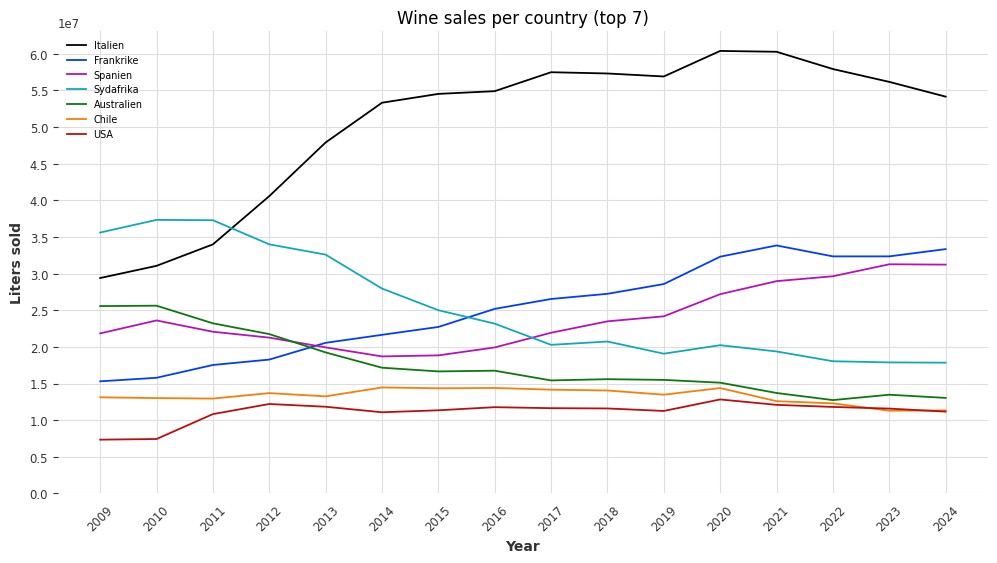

In [292]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(wine_per_country.sort_values(by=wine_per_country.transpose().index.to_list()[::-1], ascending=False).head(7).transpose(), label = wine_per_country.sort_values(by=wine_per_country.transpose().index.to_list()[::-1], ascending=False).head(7).index.to_list())
plt.grid(True)
ax.legend()
plt.title('Wine sales per country (top 7)')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='upper left',fontsize="x-small")
plt.ylabel('Liters sold')
ax.set_yticks(np.arange(0, 6.5e+7, 0.5e+7))
plt.show()

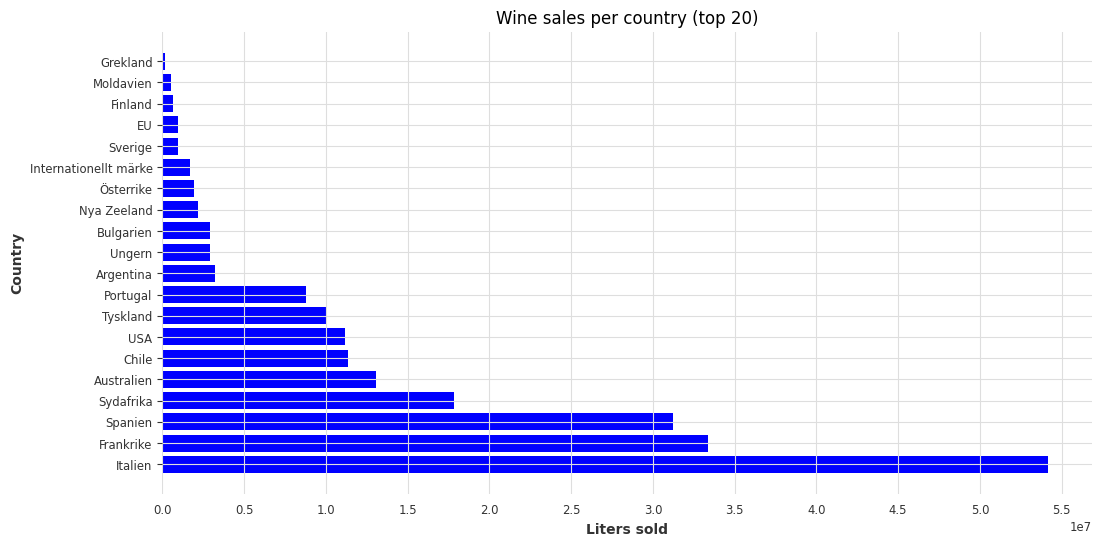

In [291]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.barh(wine_per_country.iloc[:, -1].sort_values(ascending=False).transpose().head(20).index, wine_per_country.iloc[:, -1].sort_values(ascending=False).transpose().head(20).values, color = 'blue')
plt.title('Wine sales per country (top 20)')
ax.set_xlabel('Liters sold')
ax.set_xticks(np.arange(0, 6e+7, 0.5e+7))
ax.set_ylabel('Country')
plt.savefig('wine1.png')
plt.show()

Most popular spirits categories

In [198]:
spirits_list = []
for i in range(2016-2009, len(years)):
    spirits_df = file_list[i][file_list[i]['Varugrupp'] == 'Sprit'][['Artnr', 'Artikel ID', 'Försäljning i liter', 'Varugrupp detalj']].copy()
    spirits_df.rename(columns={'Försäljning i liter' : f'Försäljning i liter år {years[i]}'}, inplace=True)
    spirits_list.append(spirits_df)

merged_spirits = reduce(lambda left, right: pd.merge(left, right, on = ['Artnr', 'Artikel ID', 'Varugrupp detalj'], how='outer'), spirits_list)
spirits_categories = merged_spirits.groupby('Varugrupp detalj').sum().drop(['Artnr', 'Artikel ID'], axis=1)
display(spirits_categories)

,Försäljning i liter år 2016,Försäljning i liter år 2017,Försäljning i liter år 2018,Försäljning i liter år 2019,Försäljning i liter år 2020,Försäljning i liter år 2021,Försäljning i liter år 2022,Försäljning i liter år 2023,Försäljning i liter år 2024
Varugrupp detalj,,,,,,,,,
Avec,1292526.275,1347931.380,1411557.680,1516795.650,1858762.270,2077916.490,1960006.550,1848755.590,1850712.880
Drinkar & Cocktails,7011386.660,7078962.405,7376964.655,7725027.715,9365843.370,9945033.860,9569782.255,9451912.910,9385249.200
Likör,2130277.450,2211036.130,2346317.250,2447981.210,2640527.670,3034472.670,3075128.840,3051437.860,3063512.670
Snaps,1053387.600,1021286.850,1002129.300,982630.250,918506.600,996798.850,992964.000,945169.800,906013.800
Säsongssprit,0,0,34481.550,33462.800,34426.750,37338.450,37816.650,55080.600,56980.050
Whisky,7326369.450,7289799.800,7294156.050,7574114.600,9276138.050,9484369.022,8736490.560,8376526.648,8196101.888


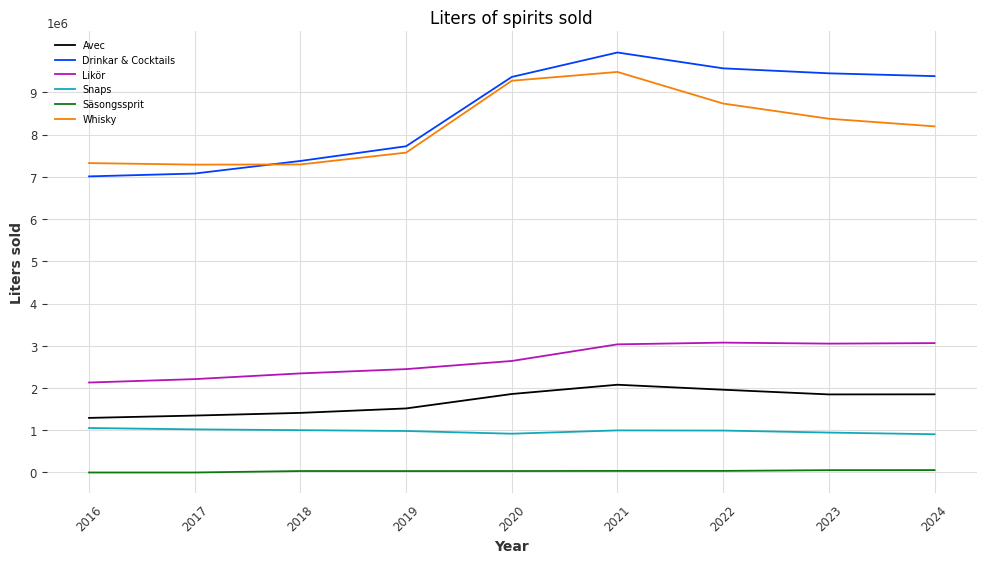

In [258]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(spirits_categories.transpose(), label=spirits_categories.index.to_list())
plt.grid(True)
ax.legend()
plt.title('Liters of spirits sold')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years[7:], rotation=45)
ax.legend(loc='upper left',fontsize="x-small")
plt.ylabel('Liters sold')
ax.set_yticks(np.arange(0, 1e+7, 0.1e+7))
plt.show()

Biggest beer sellers per country

In [199]:
beer_list = []
for i in range(len(years)):
    beer_df = file_list[i][file_list[i]['Varugrupp detalj'].isin(['Lageröl', 'Specialöl', 'Säsongsöl', 'Ljus lager', 'Mörk lager', 'Porter & Stout', 'Ale', 'Övrig öl', 'Veteöl'])][['Artnr', 'Artikel ID', 'Försäljning i liter', 'Land']].copy()
    beer_df.rename(columns={'Försäljning i liter' : f'Försäljning i liter år {years[i]}'}, inplace=True)
    beer_list.append(beer_df)

merged_beer = reduce(lambda left, right: pd.merge(left, right, on = ['Artnr', 'Artikel ID', 'Land'], how='outer'), beer_list)
merged_beer.replace(to_replace='Bosnien-Herçegovina', value='Bosnien-Hercegovina', inplace=True)
merged_beer.replace(to_replace=['Makedonien (F.Y.R.O.M)', 'Republiken Makedonien'], value='Nordmakedonien', inplace=True)
merged_beer.replace(to_replace='De Palestinska områdena', value='Palestina')
beer_per_country = merged_beer.groupby('Land').sum().drop(['Artnr', 'Artikel ID'], axis=1)
beer_per_country.drop(index=[' ursprung', 'Okänt ursprung', 'Varierande ursprung', 'Övriga ursprung', 'Serbien och Montenegro'], inplace=True)
display(beer_per_country)

,Försäljning i liter år 2009,Försäljning i liter år 2010,Försäljning i liter år 2011,Försäljning i liter år 2012,Försäljning i liter år 2013,Försäljning i liter år 2014,Försäljning i liter år 2015,Försäljning i liter år 2016,Försäljning i liter år 2017,Försäljning i liter år 2018,Försäljning i liter år 2019,Försäljning i liter år 2020,Försäljning i liter år 2021,Försäljning i liter år 2022,Försäljning i liter år 2023,Försäljning i liter år 2024
Land,,,,,,,,,,,,,,,,
Argentina,583.110,1583.420,1523.760,2570.920,2371.030,2676.035,1108.490,600.820,387.480,717.060,317.130,477.840,47.520,110.880,150.480,62.040
Armenien,0.000,0.000,270.000,783.560,259.600,0.000,0.000,0,0,0,0,0,0,0,0,0
Australien,107562.645,69542.300,63296.495,50352.535,18109.495,25510.945,14117.920,5629.170,2435.235,1102.185,1637.250,1389.165,820.710,618.690,359.625,441
Barbados,0.000,0.000,45715.480,2.130,0.000,205.920,1882.440,3164.920,1759.880,138.420,0,0,0,0,0,0
Belarus,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,160.710,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ungern,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,169.400,176.220,0,0
Venezuela,0.000,0.000,0.000,0.000,0.000,0.000,7.920,55.440,79.200,95.040,56.100,23.760,0,0,0,0
Vietnam,269.760,183.240,208.050,329.400,116.880,170.400,205.800,266.100,466.920,438.240,541.020,437.005,360.680,545.280,570.840,990.600


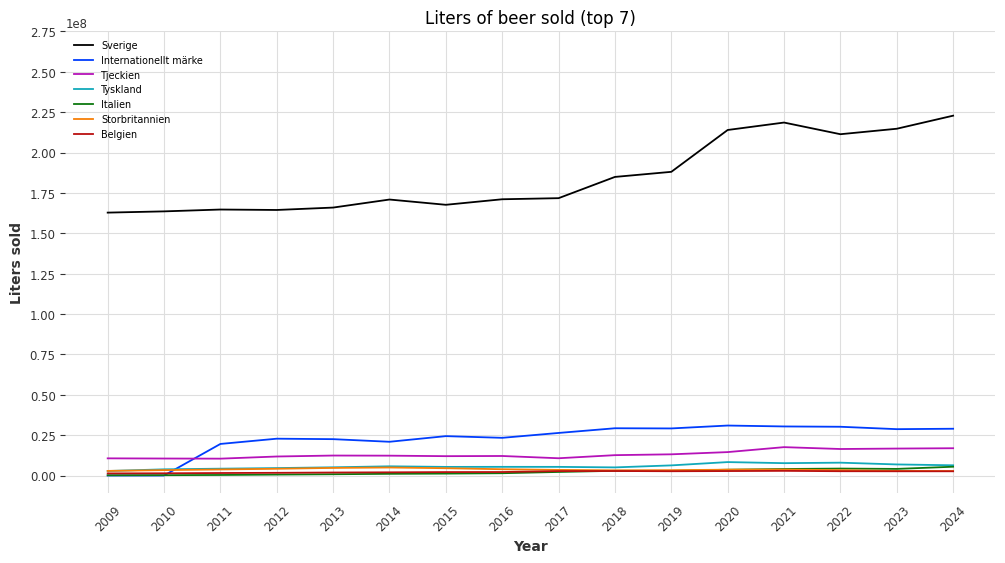

In [290]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(beer_per_country.sort_values(by=beer_per_country.transpose().index.to_list()[::-1], ascending=False).head(7).transpose(), label=beer_per_country.sort_values(by=beer_per_country.transpose().index.to_list()[::-1], ascending=False).head(7).index.to_list())
plt.grid(True)
ax.legend()
plt.title('Liters of beer sold (top 7)')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='upper left',fontsize="x-small")
plt.ylabel('Liters sold')
ax.set_yticks(np.arange(0, 3e+8, 0.25e+8))
plt.show()

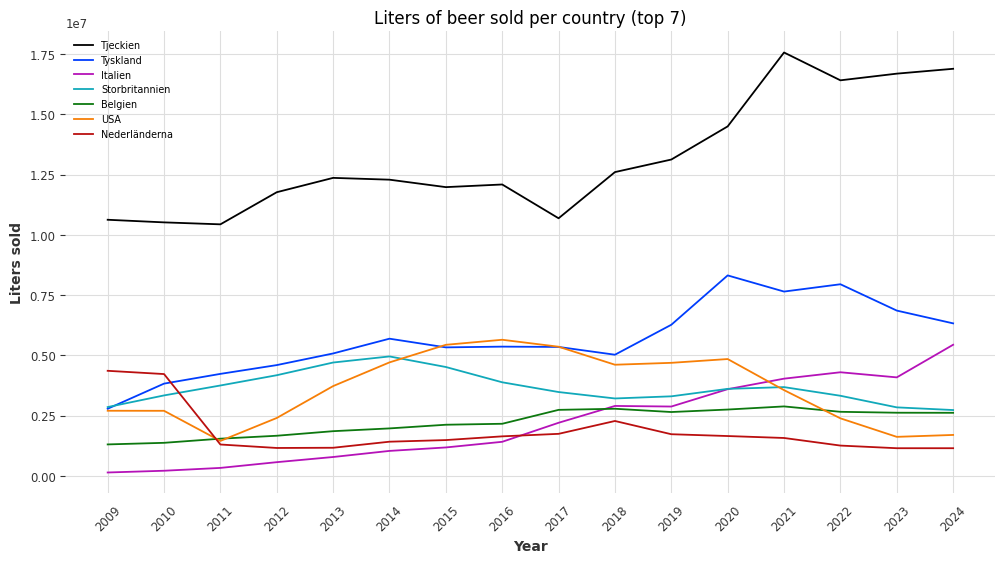

In [289]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(beer_per_country.sort_values(by=beer_per_country.transpose().index.to_list()[::-1], ascending=False)[2:].head(7).transpose(), label=beer_per_country.sort_values(by=beer_per_country.transpose().index.to_list()[::-1], ascending=False)[2:].head(7).index.to_list())
plt.grid(True)
ax.legend()
plt.title('Liters of beer sold per country (top 7)')
plt.xlabel('Year')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels=years, rotation=45)
ax.legend(loc='upper left',fontsize="x-small")
plt.ylabel('Liters sold')
ax.set_yticks(np.arange(0, 2e+7, 0.25e+7))
plt.show()

In [47]:
file_list[-1][(file_list[-1]['Land'] == 'Internationellt märke') & (file_list[-1]['Varugrupp detalj'].isin(['Lageröl', 'Specialöl', 'Säsongsöl']))]['Namn'].unique()

array(['Sol', 'Heineken', 'Miller Genuine Draft', 'Tuborg Guld', 'Bud',
       '1664', 'Kingfisher', 'Asahi Super Dry', 'Carlsberg Hof Organic',
       'Carlsberg Export', 'Red Stripe', '1664 Blanc', 'Coors',
       'Sapporo Premium Lager', 'Bellman 6,0', 'Millennium',
       'Tuborg Grön', 'Carlsberg Sort Guld', 'Cobra', 'Lagunitas IPA',
       'Grimbergen Double-Ambrée', 'Grimbergen Blonde', 'Carlsberg',
       'Blue Moon Belgian White', 'Kirin Ichiban Premium Lager',
       'Lagunitas Daytime IPA', 'Mikkeller K:rlek Höst/Vinter',
       'Mikkeller Kärlek Vår/Sommar', 'Brooklyn East IPA',
       'Brooklyn Lager', 'Honeypot Lager', 'Kirin Ichiban',
       'Founders All Day IPA', 'Pabst Blue Ribbon Original',
       'Mikkeller Burst IPA', 'Cape Point Lager Cape Brewing Company',
       'Mikkeller Peter Pale and Mary Gluten Free Pale Ale',
       'Brooklyn Pilsner', 'Brooklyn Stonewall Inn IPA', 'Corona Extra',
       'Mixpack Mastebo', 'Desperados Original'], dtype=object)

In [191]:
brooklyn_list = []
for i in range(len(years)):
    brooklyn_df = file_list[i][file_list[i]['Namn'].str.contains('Brooklyn', regex=False, na=False)][['Artnr', 'Artikel ID', 'Namn', 'Land']].copy()
    brooklyn_df.rename(columns={'Land' : f'Land {years[i]}'}, inplace=True)
    brooklyn_list.append(brooklyn_df)

merged_brooklyn = reduce(lambda left, right: pd.merge(left, right, on=['Artnr', 'Artikel ID', 'Namn'], how='outer'), brooklyn_list)
merged_brooklyn1 = merged_brooklyn.groupby('Namn', group_keys=True).apply(lambda x: x).drop(['Artnr', 'Artikel ID'], axis=1)
display(merged_brooklyn1[merged_brooklyn1['Namn'].isin(['Brooklyn Lager'])])

/var/folders/v3/79z9s7b91ml8rdq46l_fpw500000gn/T/ipykernel_37764/1364468698.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_brooklyn1 = merged_brooklyn.groupby('Namn', group_keys=True).apply(lambda x: x).drop(['Artnr', 'Artikel ID'], axis=1)


Namn Land 2009 Land 2010 Land 2011 Land 2012 Land 2013 Land 2014 Land 2015 Land 2016 Land 2017              Land 2018              Land 2019              Land 2020              Land 2021              Land 2022              Land 2023              Land 2024
Namn                                                                                                                                                                                                                                                                                       
Brooklyn Lager 2  Brooklyn Lager       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN                    NaN                    NaN  Internationellt märke  Internationellt märke  Internationellt märke  Internationellt märke  Internationellt märke
               5  Brooklyn Lager       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN                    NaN                    NaN                Sverige                Sverige                Sverige                Sverige                Sverige
               6  Brooklyn Lager       USA       USA       USA       USA       USA       USA       USA       USA       USA  Internationellt märke  Internationellt märke  Internationellt märke  Internationellt märke  Internationellt märke  Internationellt märke                    NaN
               7  Brooklyn Lager       NaN       NaN       NaN       NaN       NaN       USA       USA       USA       USA                    USA                    USA                    USA                    USA                    NaN                    NaN                    NaN

In [176]:
sum_brooklyn_int = file_list[-1][(file_list[-1]['Varugrupp'].isin(['Öl, cider & blanddryck'])) & (file_list[-1]['Namn'].str.contains('Brooklyn', regex=False)) & (file_list[-1]['Land'] == 'Internationellt märke')][['Namn','Försäljning i liter']]['Försäljning i liter'].sum()
print(sum_brooklyn_int)

786835.49999999


In [170]:
beer_per_country[beer_per_country.index.str.contains('USA', regex=False)].iloc[:, -1]

Land
USA    1694503.242
Name: Försäljning i liter år 2024, dtype: float64

In [171]:
sum_beer_usa = file_list[-1][(file_list[-1]['Varugrupp detalj'].str.contains('öl', regex=False, na=False)) & (file_list[-1]['Land'] == 'USA') & (file_list[-1]['Varugrupp'].isin(['Öl, cider & blanddryck']))]['Försäljning i liter'].sum()
print(sum_beer_usa)

1694503.2420000008


In [177]:
sum_brooklyn_int/sum_beer_usa * 100

46.43458215348694

In [288]:
sum_int = file_list[-1][(file_list[-1]['Varugrupp'].isin(['Öl, cider & blanddryck'])) & (file_list[-1]['Namn'].isin(['Lagunitas IPA', 'Blue Moon Belgian White', 'Founders All Day IPA', 'Pabst Blue Ribbon Original'])) & (file_list[-1]['Land'] == 'Internationellt märke')][['Namn','Försäljning i liter']]['Försäljning i liter'].sum()
print(sum_int)

426789.16499999


In [286]:
sum_usa = sum_beer_usa + sum_brooklyn_usa + sum_int
print(sum_usa)

3815795.648999992


In [287]:
sum_usa/sum_beer_usa * 100

225.18668329582283